In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
from typing import Any, Dict, List
import copy
import random
import scipy.stats
import deepxde as dde

Using backend: pytorch



# FedLearn Experiment: Non-iidness(Distribution)


We try to analyze the performace of FL via different distribution on different benchmark functions


The first focus is on **GRAMACY & LEE (2012) FUNCTION**
$$f(x) = \frac{\sin 10\pi x}{2x} + (x-1)^4$$
Where the input domain is $[0.5,2.5]$. By translating the function by $+1.5$ we can get
$$f(x) = \frac{- \sin 10\pi x}{2x + 3} + (x+0.5)^4$$
where the input domain is $[-1,1]$



# Define the Client class and the Server class





## Client class
attributes: 
- `client_id` 
- `model`: local model & weights
- `loss`
- `optimizer` 
- `optimizer_conf`
- `batch_size` 
- `epoches` 
- `server` 
- `accuracy` 
- `total_loss` 
- `data`
- `dataloader`


methods: 
- `setData`: set the `data` and `dataloader` of the client, then update the corresponding server's data length (`total_data`)
- `update_weights`: Reset `total_loss`, then use the `optimizer` to update the `model` in `epoches` steps. Record the `total_loss` and `accuracy`


In [2]:
class Client:
    def __init__(self,
                 client_id: Any,
                 model: torch.nn.Module,
                 loss: torch.nn.modules.loss._Loss,
                 optimizer: torch.optim.Optimizer,
                 optimizer_conf: Dict,
                 batch_size: int,
                 epochs: int,
                 server=None) -> None:
        self.client_id = client_id
        self.model = model
        self.loss = loss
        self.optimizer = optimizer(self.model.parameters(), **optimizer_conf)
        self.batch_size = batch_size
        self.epochs = epochs
        self.server = server
        self.accuracy = None
        self.total_loss = None

        self.data = None
        self.data_loader = None

    def setData(self, data):
        self.data = data
        self.data_loader = torch.utils.data.DataLoader(self.data,
                                                       batch_size=self.batch_size,
                                                       shuffle=True)
        self.server.total_data += len(self.data)

    def update_weights(self):
        for eps in range(self.epochs):
            total_loss = 0
            total_batches = 0
            total_correct = 0

            for _, (feature, label) in enumerate(self.data_loader):
                feature = feature.to(device)
                label = label.to(device)
                
                y_pred = self.model(feature)
                
                loss = self.loss(y_pred, label)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                total_batches += 1
                

            self.total_loss = total_loss / total_batches
        
        
        # self.accuracy = total_correct / (total_batches * self.batch_size)




## Server class

attributes:
- `model`
- `loss`
- `optimizer`
- `optimizer_conf`
- `n_client`
- `chosen_prob`
- `local_batch_size`
- `local_epoches`
- `total_data`
- `client_pool`
- `avg_loss`
- `avg_acc`


methods:
- `create_client`: Resets the `client_pool` to empty, then create `n_clients` of `Client` object instances with `client.model` equal to `server.model`, and append them to `client_pool`.
- `broadcast`: Let the `Client` objects in `client_pool` load the model state of the server `model`.
- `aggregate`: Reset `avg_loss` and `avg_acc`. Then randomly sample a subset of `client_pool` by a probability of `chosen_prob`. Then run `Client.update_weights` on each chosen `Client`, then record the averaged loss and accuracy to `avg_loss` and `avg_acc`. Then update the global `model` by the averaged local weights.


In [3]:
class Server:
    def __init__(self,
                 model: torch.nn.Module,
                 loss: torch.nn.modules.loss._Loss,
                 optimizer: torch.optim.Optimizer,
                 optimizer_conf: Dict,
                 n_client: int,
                 chosen_prob: float ,
                 local_batch_size: int,
                 local_epochs: int) -> None:

        # global model info
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.optimizer_conf = optimizer_conf
        self.n_client = n_client
        self.local_batch_size = local_batch_size
        self.local_epochs = local_epochs
        self.total_data = 0

        # create clients
        self.client_pool: List[Client] = []
        self.create_client()
        self.chosen_prob = chosen_prob
        self.avg_loss = 0
        self.avg_acc = 0

    def create_client(self):
        # this function is reusable, so reset client pool is needed
        self.client_pool: List[Client] = []
        self.total_data = 0

        for i in range(self.n_client):
            model = copy.deepcopy(self.model)
            new_client = Client(client_id=i,
                                model=model,
                                loss=self.loss,
                                optimizer=self.optimizer,
                                optimizer_conf=self.optimizer_conf,
                                batch_size=self.local_batch_size,
                                epochs=self.local_epochs,
                                server=self)
            self.client_pool.append(new_client)

    def broadcast(self):
        model_state_dict = copy.deepcopy(self.model.state_dict())
        for client in self.client_pool:
            client.model.load_state_dict(model_state_dict)

    def aggregate(self):
        self.avg_loss = 0
        self.avg_acc = 0
        chosen_clients = random.sample(self.client_pool,
                                       int(len(self.client_pool) * self.chosen_prob))

        global_model_weights = copy.deepcopy(self.model.state_dict())
        for key in global_model_weights:
            global_model_weights[key] = torch.zeros_like(
                global_model_weights[key])

        for client in chosen_clients:
            client.update_weights()
            # print(f"Client {client.client_id}: Loss: {client.total_loss}")
            self.avg_loss += 1 / len(chosen_clients) * client.total_loss
            # self.avg_acc += 1 / len(chosen_clients) * client.accuracy
            local_model_weights = copy.deepcopy(client.model.state_dict())
            for key in global_model_weights:
                global_model_weights[key] += 1 / len(chosen_clients) * local_model_weights[key]

        self.model.load_state_dict(global_model_weights)
        

# Data assignment method
- different amount of data
- different probability distribution
    - uniform distribution, but domains are different for each client. Level of non iid is controlled by a “sliding hyperparameter”
    - different distribution on different intervals

## different amount

In [10]:
def assign_data(ratio, clients, dataloader): 
    """
    ratio: a list that contains the ratio of data assigned to each worker;
            each element should be <=1 and sum <=1
    clients: a list of Client class
    dataloader: torch.DataLoader
    """

    total_data = []
    labels = []
    for idx, (data, label) in enumerate(dataloader):
        total_data.append(data.detach().numpy())
        labels.append(label.detach().numpy())
    
    # create list for data assignment
    assign_data = [[]for i in range(len(ratio))]
    assign_label = [[]for i in range(len(ratio))]
    
    # assign data alternatingly till satisfy the ratio
    for i in range(len(total_data)):
        loc = i%len(ratio)
        while(len(assign_data[loc]) == ratio[loc]*len(total_data)):
            loc += 1
        assign_data[loc].append(np.array(total_data)[i,:])
        assign_label[loc].append(np.array(labels)[i,:])

    for j in range(len(ratio)):
        x = np.array(assign_data[j])
        y = np.array(assign_label[j])
        client_data = TensorDataset(torch.from_numpy(x.reshape((len(x)*len(x[0]),1))).float(),
                                            torch.from_numpy(y.reshape((len(y)*len(y[0]),1))).float())
        clients[j].setData(client_data)

## different $p(x)$

### Sliding parameter $a$

For a given sliding parameter $a$ and $n\geq2$ clients, the total data $x\in [c_1, c_2]$, domain decomposition is constructued by
$$
\mathcal{D}=\{[c_1, c_1+\frac{\delta}{2^{n-2}}],[c_1+\frac{\delta}{2^{n-2}}, c_1+\frac{\delta}{2^{n-3}}],\cdots, [c_1+a, c_2]\}
$$  
where $\delta = (c_2-c_1)a$ is the sliding distance.
Thus smaller $a$ leads to larger non-iid level. 

In [45]:
def split_a(a, c1, c2, n, func, clients):
    """
    a: sliding parameter to control level of non-iid;
    c1, c2: left and right bound of sampling interval;
    n: the number of points with in each sub-interval;
    func: function to sample training data from
    clinets: a list of Client class
    """

    split = sorted([c1 + (c2-c1) * a * 0.5 ** n for n in range(0, len(clients)-1)])

    # set the left most and right most interval
    tempx = np.linspace(c1, split[0], n)[:,None]
    tempy = func(tempx)
    tempdata = TensorDataset(torch.from_numpy(tempx).float(), torch.from_numpy(tempy).float())
    clients[0].setData(tempdata)

    tempx = np.linspace(split[-1], c2, n)[:,None]
    tempy = func(tempx)
    tempdata = TensorDataset(torch.from_numpy(tempx).float(), torch.from_numpy(tempy).float())
    clients[-1].setData(tempdata)

    for i in range(len(split)-1):
        tempx = np.linspace(split[i], split[i+1], n)[:,None]
        tempy = func(tempx)
        tempdata = TensorDataset(torch.from_numpy(tempx).float(), torch.from_numpy(tempy).float())
        clients[i+1].setData(tempdata)
        


### Different $p_{i}(x)$

For $n\geq2$ clients and $x\in [c_1, c_2]$, the data are split into $n$ equispace subintervals with pre-defined pdf:
$$
\mathcal{P}=\{p_1(x), p_2(x),\cdots, p_n(x)\}
$$  
where $p_i(x)$ by default is set to be uniform. 

In [39]:
def diff_p(p, c1, c2, n, func, clients):
    """
    p: a list of probability distribution to control level of non-iid;
    c1, c2: left and right bound of sampling interval;
    n: the number of points with in each sub-interval;
    clinets: a list of Client class
    """

    split = sorted([ (c2-c1)/len(clients) * (n+1) for n in range(0, len(clients)+1)])

    # set the left most and right most interval

    for i in range(len(split)-1):
        tempx = np.linspace(split[i], split[i+1], n)
        tempy = func(tempx)
        
        train = TensorDataset(torch.from_numpy(tempx).float(), torch.from_numpy(tempy).float())
        temp_data= DataLoader(train, batch_size=100, shuffle=False)
        clients[i+1].setData(temp_data)

## Baseline Model 

In [38]:
def func(x):
    return -np.sin(10*np.pi*x)/(2*x+3) + (x+0.5)**4

Compiling model...
'compile' took 0.001568 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.36e+00]    [2.26e+00]    [9.97e-01]    
1000      [9.50e-02]    [9.54e-02]    [2.05e-01]    
2000      [9.24e-02]    [9.22e-02]    [2.01e-01]    
3000      [7.32e-02]    [7.08e-02]    [1.76e-01]    
4000      [4.20e-02]    [4.02e-02]    [1.33e-01]    
5000      [2.77e-02]    [2.74e-02]    [1.10e-01]    
6000      [1.92e-02]    [1.93e-02]    [9.20e-02]    
7000      [1.34e-02]    [1.36e-02]    [7.72e-02]    
8000      [7.55e-03]    [7.61e-03]    [5.78e-02]    
9000      [4.97e-03]    [5.02e-03]    [4.69e-02]    
10000     [6.30e-04]    [6.35e-04]    [1.67e-02]    

Best model at step 10000:
  train loss: 6.30e-04
  test loss: 6.35e-04
  test metric: [1.67e-02]

'train' took 16.336899 s

Saving loss history to /Users/apple/Desktop/proj_deeponet_federated/loss.dat ...
Saving training data to /Users/apple/Desktop/proj_deeponet_federated/train.dat ...
Saving tes

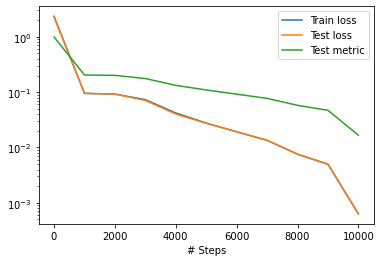

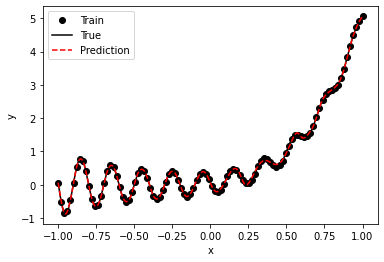

In [39]:
geom = dde.geometry.Interval(-1,1)
num_train = 100
num_test = 1000
data = dde.data.Function(geom, func, num_train, num_test)

layer_size = [1] + [64] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(
    layer_size,
    activation,
    initializer,
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Neural Network Structure

In [26]:
# Define NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,1)
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

## Test function

In [56]:
def test(federated_model):
    federated_model.eval()
    test_loss = 0
    for data, target in test_loader:
        output = federated_model(data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()
    test_loss /= len(test_loader.dataset)
    return test_loss

# Test for different amount of data
- number of clients increase from 2 to 5
    - 2: a = 0.1, 0.2, 0.3, 0.4, 0.5
    - 3: a = 0.1~0.9
    - 4: a = ...
    - 5: a = ..,

- training data: 200
- testing data: 1000
- data are uniform 

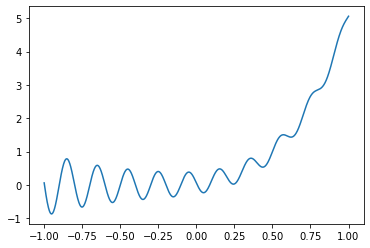

In [28]:
# Data preparation
ntrain = 200
ntest = 1000
x = np.linspace(-1, 1, ntest)
y = func(x)
np.savetxt('Gramacy&Lee(2012)_test.txt', np.vstack((x, y)).T)
plt.plot(x,y)

In [54]:
x_test = torch.from_numpy(np.loadtxt('Gramacy&Lee(2012)_test.txt')[:, :1]).float()
y_test = torch.from_numpy(np.loadtxt('Gramacy&Lee(2012)_test.txt')[:, 1:]).float()
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test, batch_size=ntest, shuffle=False)

In [65]:
def run(num_clients, sliding_param, fname):
    # initialize parameters
    torch.manual_seed(1)
    chosen_prob = 1
    local_batch_size = 10
    criteria = nn.MSELoss()
    optimizer = optim.Adam
    optimizer_conf = dict(lr=0.001)

    n_client = num_clients
    local_epochs = 1
    epochs = 10000
    sliding_para = sliding_param

    # construct server and clients
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Net().to(device)

    server = Server(
        model=model,
        loss=criteria,
        optimizer=optimizer,
        n_client=n_client,
        chosen_prob=chosen_prob,
        optimizer_conf=optimizer_conf,
        local_batch_size=local_batch_size,
        local_epochs=local_epochs
        )

    # construct non-iid data
    clients = server.client_pool
    split_a(sliding_para, -1, 1, 100, func, clients)

    # train and save results
    for epoch in range(epochs):
        server.aggregate()
        server.broadcast()
        with torch.no_grad():
            testloss = test(server.model)

        if epoch % 100 == 0:
            print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

    y_pred = model(x_test).detach().numpy()
    np.savetxt(fname, y_pred)


In [63]:
for a in [0.1, 0.2, 0.3, 0.4, 0.5]:
    run(2, a, "test_{}_{}.txt".format(2,a)) 

<ipython-input-56-92e2757bae34>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 0.570463341474533, test_loss: 2200.27625
Epoch: 100, Overall_loss: 0.11576516442000866, test_loss: 3214.496
Epoch: 200, Overall_loss: 0.050228605233132835, test_loss: 3344.8245
Epoch: 300, Overall_loss: 0.03632133963983506, test_loss: 3371.1035
Epoch: 400, Overall_loss: 0.026864856658357892, test_loss: 3335.78375
Epoch: 500, Overall_loss: 0.024663976210285907, test_loss: 3298.2685
Epoch: 600, Overall_loss: 0.020895626925630496, test_loss: 3369.10175
Epoch: 700, Overall_loss: 0.020022410957608372, test_loss: 3388.0525
Epoch: 800, Overall_loss: 0.014693441521376372, test_loss: 3390.888
Epoch: 900, Overall_loss: 0.011988387400560897, test_loss: 3370.25375
Epoch: 1000, Overall_loss: 0.013145073447958566, test_loss: 3362.5475
Epoch: 1100, Overall_loss: 0.013742354519854416, test_loss: 3416.5455
Epoch: 1200, Overall_loss: 0.011916175964233843, test_loss: 3429.579
Epoch: 1300, Overall_loss: 0.010947568756819237, test_loss: 3409.729
Epoch: 1400, Overall_loss: 0.00843806

Epoch: 1800, Overall_loss: 0.0008074321354797575, test_loss: 3421.141
Epoch: 1900, Overall_loss: 0.0024827351095154885, test_loss: 3411.3735
Epoch: 2000, Overall_loss: 0.0009811393581912852, test_loss: 3445.725
Epoch: 2100, Overall_loss: 0.0005245136781013571, test_loss: 3423.698
Epoch: 2200, Overall_loss: 0.0008623221416200977, test_loss: 3457.0195
Epoch: 2300, Overall_loss: 0.001302916373606422, test_loss: 3400.93575
Epoch: 2400, Overall_loss: 0.0001982614307053154, test_loss: 3424.1515
Epoch: 2500, Overall_loss: 0.00027033199185098054, test_loss: 3414.63075
Epoch: 2600, Overall_loss: 0.0025432471731619446, test_loss: 3408.198
Epoch: 2700, Overall_loss: 0.00031239564887073354, test_loss: 3417.0415
Epoch: 2800, Overall_loss: 0.003673334709765186, test_loss: 3381.312
Epoch: 2900, Overall_loss: 0.0004067592864885228, test_loss: 3421.8225
Epoch: 3000, Overall_loss: 0.00024172087069018744, test_loss: 3436.709
Epoch: 3100, Overall_loss: 0.00023695694990237827, test_loss: 3423.35025
Epoch: 

Epoch: 3500, Overall_loss: 0.002540504602075089, test_loss: 3450.5835
Epoch: 3600, Overall_loss: 0.0005265260848318576, test_loss: 3424.7195
Epoch: 3700, Overall_loss: 0.0006699881065287627, test_loss: 3398.933
Epoch: 3800, Overall_loss: 0.0006226314773812192, test_loss: 3421.908
Epoch: 3900, Overall_loss: 0.002693566981179174, test_loss: 3443.3125
Epoch: 4000, Overall_loss: 0.0005849756958923535, test_loss: 3421.08825
Epoch: 4100, Overall_loss: 0.0005924134027736727, test_loss: 3427.68825
Epoch: 4200, Overall_loss: 0.0003141540145861654, test_loss: 3437.077
Epoch: 4300, Overall_loss: 0.0004260933109435427, test_loss: 3413.78275
Epoch: 4400, Overall_loss: 0.0005501076426298823, test_loss: 3438.19925
Epoch: 4500, Overall_loss: 0.0005266413043500506, test_loss: 3421.762
Epoch: 4600, Overall_loss: 0.00013537163667933782, test_loss: 3426.06125
Epoch: 4700, Overall_loss: 0.0002960009819616971, test_loss: 3410.3155
Epoch: 4800, Overall_loss: 0.0005544492309127236, test_loss: 3414.302
Epoch: 

In [66]:
for a in [0.1, 0.2, 0.3, 0.4, 0.5]:
    run(2, a, "test_{}_{}_10000.txt".format(2,a)) 

<ipython-input-56-92e2757bae34>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.0377983741462231, test_loss: 1893.832
Epoch: 100, Overall_loss: 0.19758701100945472, test_loss: 3395.356
Epoch: 200, Overall_loss: 0.19245991688221692, test_loss: 3467.1905
Epoch: 300, Overall_loss: 0.15895291641354561, test_loss: 3343.5495
Epoch: 400, Overall_loss: 0.13431908320635558, test_loss: 3220.94625
Epoch: 500, Overall_loss: 0.21677668057382107, test_loss: 3413.92
Epoch: 600, Overall_loss: 0.18620125222951173, test_loss: 3191.78
Epoch: 700, Overall_loss: 0.15086150374263524, test_loss: 3056.06825
Epoch: 800, Overall_loss: 0.13096978198736905, test_loss: 3208.27275
Epoch: 900, Overall_loss: 0.13528854362666606, test_loss: 3304.7455
Epoch: 1000, Overall_loss: 0.10910065798088908, test_loss: 3302.943
Epoch: 1100, Overall_loss: 0.0868726502172649, test_loss: 3331.48775
Epoch: 1200, Overall_loss: 0.10019134748727083, test_loss: 3409.027
Epoch: 1300, Overall_loss: 0.08022825256921351, test_loss: 3416.619
Epoch: 1400, Overall_loss: 0.047267859894782306, test

Epoch: 1800, Overall_loss: 0.016633910755626858, test_loss: 3384.07125
Epoch: 1900, Overall_loss: 0.01849834345994168, test_loss: 3564.1885
Epoch: 2000, Overall_loss: 0.014754093550436664, test_loss: 3388.4595
Epoch: 2100, Overall_loss: 0.01592647022625897, test_loss: 3386.5685
Epoch: 2200, Overall_loss: 0.014929750154260546, test_loss: 3416.05
Epoch: 2300, Overall_loss: 0.01438185036822688, test_loss: 3508.696
Epoch: 2400, Overall_loss: 0.015952739756903613, test_loss: 3331.96775
Epoch: 2500, Overall_loss: 0.0256965976797801, test_loss: 3269.717
Epoch: 2600, Overall_loss: 0.013822646150219952, test_loss: 3365.9105
Epoch: 2700, Overall_loss: 0.014309614082958432, test_loss: 3373.05275
Epoch: 2800, Overall_loss: 0.013731842546258121, test_loss: 3339.8575
Epoch: 2900, Overall_loss: 0.013468331297917758, test_loss: 3409.8185
Epoch: 3000, Overall_loss: 0.012780174960062141, test_loss: 3444.89
Epoch: 3100, Overall_loss: 0.012559835767024196, test_loss: 3393.1415
Epoch: 3200, Overall_loss: 0

Epoch: 3600, Overall_loss: 0.01214651893824339, test_loss: 3306.693
Epoch: 3700, Overall_loss: 0.009314728722165455, test_loss: 3520.64425
Epoch: 3800, Overall_loss: 0.008378588808409403, test_loss: 3419.37275
Epoch: 3900, Overall_loss: 0.008031729726644699, test_loss: 3369.13275
Epoch: 4000, Overall_loss: 0.007979639664154093, test_loss: 3384.15425
Epoch: 4100, Overall_loss: 0.007537653335020877, test_loss: 3444.044
Epoch: 4200, Overall_loss: 0.007327420197543688, test_loss: 3391.33075
Epoch: 4300, Overall_loss: 0.007117002140148543, test_loss: 3427.23425
Epoch: 4400, Overall_loss: 0.004635555325876339, test_loss: 3399.745
Epoch: 4500, Overall_loss: 0.003976691532807308, test_loss: 3444.804
Epoch: 4600, Overall_loss: 0.004802416569873458, test_loss: 3426.74425
Epoch: 4700, Overall_loss: 0.0032285657434840687, test_loss: 3408.539
Epoch: 4800, Overall_loss: 0.0029491407280147542, test_loss: 3427.369
Epoch: 4900, Overall_loss: 0.0029159539249121735, test_loss: 3428.10225
Epoch: 5000, Ove

Epoch: 5300, Overall_loss: 0.0022492645526654086, test_loss: 3460.267
Epoch: 5400, Overall_loss: 0.00037782686194987036, test_loss: 3438.5705
Epoch: 5500, Overall_loss: 0.0003611221996834502, test_loss: 3405.5705
Epoch: 5600, Overall_loss: 0.000531630365003366, test_loss: 3423.37025
Epoch: 5700, Overall_loss: 0.0006008181120705559, test_loss: 3445.4835
Epoch: 5800, Overall_loss: 0.016855124494759365, test_loss: 3499.5245
Epoch: 5900, Overall_loss: 0.0005353609776648227, test_loss: 3410.441
Epoch: 6000, Overall_loss: 0.0004316034413932357, test_loss: 3428.62625
Epoch: 6100, Overall_loss: 0.0007521456802351168, test_loss: 3404.5265
Epoch: 6200, Overall_loss: 0.0004222123881845619, test_loss: 3426.7565
Epoch: 6300, Overall_loss: 0.00888292149611516, test_loss: 3499.73525
Epoch: 6400, Overall_loss: 0.0004271613852324663, test_loss: 3415.186
Epoch: 6500, Overall_loss: 0.00035538032661861505, test_loss: 3427.504
Epoch: 6600, Overall_loss: 0.002085609557980206, test_loss: 3433.67825
Epoch: 67

Epoch: 7000, Overall_loss: 0.0003013952396941022, test_loss: 3436.141
Epoch: 7100, Overall_loss: 8.449747820122866e-05, test_loss: 3423.0695
Epoch: 7200, Overall_loss: 0.004877574789497885, test_loss: 3441.5175
Epoch: 7300, Overall_loss: 0.00013666635895788205, test_loss: 3425.16575
Epoch: 7400, Overall_loss: 0.0006440384906454711, test_loss: 3437.2865
Epoch: 7500, Overall_loss: 0.0027641575012239627, test_loss: 3438.748
Epoch: 7600, Overall_loss: 0.00015119587515073364, test_loss: 3415.584
Epoch: 7700, Overall_loss: 0.0005912095131861861, test_loss: 3410.745
Epoch: 7800, Overall_loss: 0.00016668961188770481, test_loss: 3409.78025
Epoch: 7900, Overall_loss: 0.00041111991695288454, test_loss: 3409.087
Epoch: 8000, Overall_loss: 0.0001576912544805964, test_loss: 3416.4415
Epoch: 8100, Overall_loss: 0.0010518915602006017, test_loss: 3425.96725
Epoch: 8200, Overall_loss: 0.00022092644721851684, test_loss: 3435.29575
Epoch: 8300, Overall_loss: 5.758841243732604e-05, test_loss: 3424.30725
Ep

In [64]:
for n in [4, 5, 3]:
    for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        run(n, a, "test_{}_{}.txt".format(n,a))

<ipython-input-56-92e2757bae34>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 0.2659159784670919, test_loss: 2244.24725
Epoch: 100, Overall_loss: 0.07756094774231315, test_loss: 3269.4795
Epoch: 200, Overall_loss: 0.07552681495435537, test_loss: 3334.03275
Epoch: 300, Overall_loss: 0.04638309217989445, test_loss: 2953.039
Epoch: 400, Overall_loss: 0.02882301001518499, test_loss: 3196.794
Epoch: 500, Overall_loss: 0.027508466951258016, test_loss: 3352.1095
Epoch: 600, Overall_loss: 0.027993859247726505, test_loss: 3302.598
Epoch: 700, Overall_loss: 0.0295736353711618, test_loss: 2601.28175
Epoch: 800, Overall_loss: 0.023407565127308773, test_loss: 2975.019
Epoch: 900, Overall_loss: 0.018091687246851507, test_loss: 2916.13025
Epoch: 1000, Overall_loss: 0.01620881999720041, test_loss: 3212.421
Epoch: 1100, Overall_loss: 0.015816073661517292, test_loss: 3267.04675
Epoch: 1200, Overall_loss: 0.015009354393009744, test_loss: 3292.9535
Epoch: 1300, Overall_loss: 0.01535021073095777, test_loss: 3333.364
Epoch: 1400, Overall_loss: 0.01557438086356

Epoch: 1800, Overall_loss: 0.007524728744283493, test_loss: 3326.03675
Epoch: 1900, Overall_loss: 0.006416188980801962, test_loss: 3436.721
Epoch: 2000, Overall_loss: 0.01126523372640804, test_loss: 3352.04975
Epoch: 2100, Overall_loss: 0.007486359445101698, test_loss: 3375.9015
Epoch: 2200, Overall_loss: 0.006882438463344443, test_loss: 3312.376
Epoch: 2300, Overall_loss: 0.007122465362590446, test_loss: 3314.627
Epoch: 2400, Overall_loss: 0.004654297819433851, test_loss: 3387.306
Epoch: 2500, Overall_loss: 0.007212637655447907, test_loss: 3393.543
Epoch: 2600, Overall_loss: 0.005096675509321358, test_loss: 3569.3265
Epoch: 2700, Overall_loss: 0.007120664350804873, test_loss: 3391.0745
Epoch: 2800, Overall_loss: 0.005439388906052045, test_loss: 3473.96125
Epoch: 2900, Overall_loss: 0.006950998568208888, test_loss: 3462.43025
Epoch: 3000, Overall_loss: 0.005536278191721067, test_loss: 3395.02975
Epoch: 3100, Overall_loss: 0.00591743143468193, test_loss: 3422.0795
Epoch: 3200, Overall_l

Epoch: 3600, Overall_loss: 0.0009849809789102438, test_loss: 3418.0325
Epoch: 3700, Overall_loss: 0.0011132464118418282, test_loss: 3462.4185
Epoch: 3800, Overall_loss: 0.00037579939198622013, test_loss: 3436.3055
Epoch: 3900, Overall_loss: 0.00029763578186248196, test_loss: 3429.6955
Epoch: 4000, Overall_loss: 0.0005428854084129853, test_loss: 3416.5465
Epoch: 4100, Overall_loss: 0.0004988678447261918, test_loss: 3433.08325
Epoch: 4200, Overall_loss: 0.0006927350836122059, test_loss: 3432.148
Epoch: 4300, Overall_loss: 0.0003243597460368619, test_loss: 3419.92325
Epoch: 4400, Overall_loss: 0.00044184058342580104, test_loss: 3424.1885
Epoch: 4500, Overall_loss: 0.0010857769455469679, test_loss: 3445.9195
Epoch: 4600, Overall_loss: 0.001189060443175549, test_loss: 3412.6625
Epoch: 4700, Overall_loss: 0.0003315573361305724, test_loss: 3430.36325
Epoch: 4800, Overall_loss: 0.0006173529063744354, test_loss: 3451.33025
Epoch: 4900, Overall_loss: 0.0011359991291101323, test_loss: 3449.10225


Epoch: 300, Overall_loss: 0.09768243748694658, test_loss: 3620.68125
Epoch: 400, Overall_loss: 0.08247308873105794, test_loss: 3634.37875
Epoch: 500, Overall_loss: 0.07392534440150485, test_loss: 3429.8845
Epoch: 600, Overall_loss: 0.02915417467156658, test_loss: 3273.7725
Epoch: 700, Overall_loss: 0.01674419699193095, test_loss: 3361.20025
Epoch: 800, Overall_loss: 0.011256626782596868, test_loss: 3368.67625
Epoch: 900, Overall_loss: 0.008826667868197547, test_loss: 3424.19225
Epoch: 1000, Overall_loss: 0.0063396708406799, test_loss: 3435.517
Epoch: 1100, Overall_loss: 0.00628858830423269, test_loss: 3377.563
Epoch: 1200, Overall_loss: 0.00488060095522087, test_loss: 3333.93275
Epoch: 1300, Overall_loss: 0.006169781582138966, test_loss: 3127.9565
Epoch: 1400, Overall_loss: 0.0051851540611096425, test_loss: 3243.653
Epoch: 1500, Overall_loss: 0.00629853368318436, test_loss: 3332.2175
Epoch: 1600, Overall_loss: 0.001091002951397968, test_loss: 3427.853
Epoch: 1700, Overall_loss: 0.00157

Epoch: 2100, Overall_loss: 0.012020483335436441, test_loss: 3307.913
Epoch: 2200, Overall_loss: 0.01282665122424078, test_loss: 3543.35975
Epoch: 2300, Overall_loss: 0.01028382845433953, test_loss: 3576.6025
Epoch: 2400, Overall_loss: 0.009270591086242348, test_loss: 3466.7365
Epoch: 2500, Overall_loss: 0.010125492438382936, test_loss: 3522.20375
Epoch: 2600, Overall_loss: 0.008644257023115642, test_loss: 3342.956
Epoch: 2700, Overall_loss: 0.008944545385456878, test_loss: 3506.0965
Epoch: 2800, Overall_loss: 0.012445094013437484, test_loss: 3386.396
Epoch: 2900, Overall_loss: 0.007205443367201952, test_loss: 3486.882
Epoch: 3000, Overall_loss: 0.007124800086094184, test_loss: 3451.444
Epoch: 3100, Overall_loss: 0.009784640205325558, test_loss: 3425.766
Epoch: 3200, Overall_loss: 0.007162338434718549, test_loss: 3480.863
Epoch: 3300, Overall_loss: 0.005823891937325242, test_loss: 3398.5435
Epoch: 3400, Overall_loss: 0.005334446739434498, test_loss: 3388.2
Epoch: 3500, Overall_loss: 0.0

Epoch: 4000, Overall_loss: 0.009786479042231806, test_loss: 3394.0345
Epoch: 4100, Overall_loss: 0.0083569854146117, test_loss: 3366.1725
Epoch: 4200, Overall_loss: 0.008105837557541237, test_loss: 3347.335
Epoch: 4300, Overall_loss: 0.009781386972827022, test_loss: 3450.43625
Epoch: 4400, Overall_loss: 0.008140785939322086, test_loss: 3354.1365
Epoch: 4500, Overall_loss: 0.009226949438307203, test_loss: 3416.8325
Epoch: 4600, Overall_loss: 0.010034800205539797, test_loss: 3385.2885
Epoch: 4700, Overall_loss: 0.008623542271088807, test_loss: 3393.60175
Epoch: 4800, Overall_loss: 0.007949966014057282, test_loss: 3383.9025
Epoch: 4900, Overall_loss: 0.007452325332924375, test_loss: 3374.608
Epoch: 0, Overall_loss: 0.2850556641817093, test_loss: 2080.439625
Epoch: 100, Overall_loss: 0.09161834068596364, test_loss: 3601.865
Epoch: 200, Overall_loss: 0.07499113891273737, test_loss: 3855.017
Epoch: 300, Overall_loss: 0.06743274666368962, test_loss: 4026.5155
Epoch: 400, Overall_loss: 0.05148

Epoch: 800, Overall_loss: 0.0073319401073968045, test_loss: 3470.49925
Epoch: 900, Overall_loss: 0.007263582019222668, test_loss: 3579.6045
Epoch: 1000, Overall_loss: 0.007339961483048683, test_loss: 3547.03875
Epoch: 1100, Overall_loss: 0.009408466860477346, test_loss: 3498.011
Epoch: 1200, Overall_loss: 0.006394509451529301, test_loss: 3413.8955
Epoch: 1300, Overall_loss: 0.00611526611915906, test_loss: 3571.19325
Epoch: 1400, Overall_loss: 0.006506763917532226, test_loss: 3511.1765
Epoch: 1500, Overall_loss: 0.004508828538855597, test_loss: 3462.7115
Epoch: 1600, Overall_loss: 0.007744569289352513, test_loss: 3495.94675
Epoch: 1700, Overall_loss: 0.003823264075454063, test_loss: 3392.77825
Epoch: 1800, Overall_loss: 0.0036617197375016985, test_loss: 3419.44275
Epoch: 1900, Overall_loss: 0.0038541604022611867, test_loss: 3421.63225
Epoch: 2000, Overall_loss: 0.00442617603472172, test_loss: 3427.6925
Epoch: 2100, Overall_loss: 0.003334134473825543, test_loss: 3391.3225
Epoch: 2200, Ov

Epoch: 2500, Overall_loss: 0.0009791301685618237, test_loss: 3281.571
Epoch: 2600, Overall_loss: 0.0008843564575363417, test_loss: 3285.58125
Epoch: 2700, Overall_loss: 0.000529403207328869, test_loss: 3297.637
Epoch: 2800, Overall_loss: 0.000560627964878222, test_loss: 3290.45525
Epoch: 2900, Overall_loss: 0.0009875151513551827, test_loss: 3283.61725
Epoch: 3000, Overall_loss: 0.0007650845524040051, test_loss: 3322.7905
Epoch: 3100, Overall_loss: 0.0006412382805865491, test_loss: 3302.4245
Epoch: 3200, Overall_loss: 0.0007854739628965037, test_loss: 3323.097
Epoch: 3300, Overall_loss: 0.001063431657094043, test_loss: 3331.968
Epoch: 3400, Overall_loss: 0.0003340283551733592, test_loss: 3348.591
Epoch: 3500, Overall_loss: 0.0005836137822188904, test_loss: 3381.05425
Epoch: 3600, Overall_loss: 0.00047566740697220673, test_loss: 3357.198
Epoch: 3700, Overall_loss: 0.00030008141920916386, test_loss: 3361.972
Epoch: 3800, Overall_loss: 0.0002947190622944618, test_loss: 3397.75575
Epoch: 39

Epoch: 4200, Overall_loss: 0.00023028577258325336, test_loss: 3434.549
Epoch: 4300, Overall_loss: 0.00046681972332104725, test_loss: 3422.408
Epoch: 4400, Overall_loss: 0.0004390076419137283, test_loss: 3431.586
Epoch: 4500, Overall_loss: 0.000983558832831477, test_loss: 3442.01025
Epoch: 4600, Overall_loss: 0.0011041026220482309, test_loss: 3442.71425
Epoch: 4700, Overall_loss: 0.0001717496173417506, test_loss: 3434.714
Epoch: 4800, Overall_loss: 0.00012156519642303464, test_loss: 3417.653
Epoch: 4900, Overall_loss: 0.0006631320276937914, test_loss: 3408.4865
Epoch: 0, Overall_loss: 0.4316647440195084, test_loss: 2100.833
Epoch: 100, Overall_loss: 0.09802946063379447, test_loss: 3446.06475
Epoch: 200, Overall_loss: 0.07072142145286003, test_loss: 3435.6
Epoch: 300, Overall_loss: 0.03256069807879006, test_loss: 3394.769
Epoch: 400, Overall_loss: 0.023299668005590017, test_loss: 3370.5525
Epoch: 500, Overall_loss: 0.020746910352803145, test_loss: 3517.613
Epoch: 600, Overall_loss: 0.016

Epoch: 1000, Overall_loss: 0.009877452626339316, test_loss: 3390.92825
Epoch: 1100, Overall_loss: 0.010745368913679462, test_loss: 3386.57925
Epoch: 1200, Overall_loss: 0.011461826846546803, test_loss: 3404.70325
Epoch: 1300, Overall_loss: 0.010827691859837311, test_loss: 3359.7225
Epoch: 1400, Overall_loss: 0.00894436944387659, test_loss: 3423.0145
Epoch: 1500, Overall_loss: 0.008274239655838754, test_loss: 3454.037
Epoch: 1600, Overall_loss: 0.007720725929417919, test_loss: 3433.97625
Epoch: 1700, Overall_loss: 0.008463735634480447, test_loss: 3406.5515
Epoch: 1800, Overall_loss: 0.007039133545428436, test_loss: 3393.91775
Epoch: 1900, Overall_loss: 0.00734854711239071, test_loss: 3394.72925
Epoch: 2000, Overall_loss: 0.007218453475798014, test_loss: 3421.0725
Epoch: 2100, Overall_loss: 0.008249135563285865, test_loss: 3418.59425
Epoch: 2200, Overall_loss: 0.007404652425005528, test_loss: 3410.171
Epoch: 2300, Overall_loss: 0.006699542649827586, test_loss: 3385.144
Epoch: 2400, Overa

Epoch: 2700, Overall_loss: 0.00022043291961987654, test_loss: 3414.91125
Epoch: 2800, Overall_loss: 0.00047851411194036093, test_loss: 3452.026
Epoch: 2900, Overall_loss: 0.0018454764309960106, test_loss: 3508.335
Epoch: 3000, Overall_loss: 6.552876373765077e-05, test_loss: 3420.74925
Epoch: 3100, Overall_loss: 0.00039815031853625743, test_loss: 3432.6165
Epoch: 3200, Overall_loss: 0.00041998397549226256, test_loss: 3420.065
Epoch: 3300, Overall_loss: 0.0002895139590388377, test_loss: 3429.768
Epoch: 3400, Overall_loss: 0.00023103327260590352, test_loss: 3416.7505
Epoch: 3500, Overall_loss: 0.0004034861710958163, test_loss: 3418.1045
Epoch: 3600, Overall_loss: 0.00011439230844795626, test_loss: 3418.7285
Epoch: 3700, Overall_loss: 0.0002971938595995501, test_loss: 3416.042
Epoch: 3800, Overall_loss: 0.00013182890755463934, test_loss: 3417.3355
Epoch: 3900, Overall_loss: 0.00013463062574980237, test_loss: 3418.80275
Epoch: 4000, Overall_loss: 0.0001430286509275902, test_loss: 3414.7725


Epoch: 4400, Overall_loss: 0.00031288890562185164, test_loss: 3420.6225
Epoch: 4500, Overall_loss: 0.0008790000210865401, test_loss: 3432.949
Epoch: 4600, Overall_loss: 0.0013855699532238455, test_loss: 3441.071
Epoch: 4700, Overall_loss: 0.00040729977370877654, test_loss: 3424.27375
Epoch: 4800, Overall_loss: 0.00018400810116266558, test_loss: 3412.48025
Epoch: 4900, Overall_loss: 0.00020168323162579328, test_loss: 3414.743
Epoch: 0, Overall_loss: 0.4121307596564293, test_loss: 2181.6015
Epoch: 100, Overall_loss: 0.07083413794171065, test_loss: 3358.285
Epoch: 200, Overall_loss: 0.06825697996731227, test_loss: 3342.91525
Epoch: 300, Overall_loss: 0.06149908785761605, test_loss: 3292.43
Epoch: 400, Overall_loss: 0.06097380255863148, test_loss: 3295.066
Epoch: 500, Overall_loss: 0.04528984499969131, test_loss: 3079.3775
Epoch: 600, Overall_loss: 0.03416702640873457, test_loss: 3223.9815
Epoch: 700, Overall_loss: 0.03196359035913095, test_loss: 3285.68575
Epoch: 800, Overall_loss: 0.0316

In [ ]:
for n in [4, 5, 3]:
    for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        run(n, a, "test_{}_{}_10000.txt".format(n,a))

<ipython-input-56-92e2757bae34>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 0.552201902680099, test_loss: 2180.2715
Epoch: 100, Overall_loss: 0.15223481385037305, test_loss: 3092.734
Epoch: 200, Overall_loss: 0.1392382558900863, test_loss: 3266.628
Epoch: 300, Overall_loss: 0.13333662776276467, test_loss: 3290.3605
Epoch: 400, Overall_loss: 0.13204751405864953, test_loss: 3385.912
Epoch: 500, Overall_loss: 0.12926770010963082, test_loss: 3389.293
Epoch: 600, Overall_loss: 0.13107753004878758, test_loss: 3435.3545
Epoch: 700, Overall_loss: 0.13156994991004467, test_loss: 3414.0995
Epoch: 800, Overall_loss: 0.13520979825407267, test_loss: 3380.833
Epoch: 900, Overall_loss: 0.1279153750278056, test_loss: 3391.5595
Epoch: 1000, Overall_loss: 0.12468852060846985, test_loss: 3396.03425
Epoch: 1100, Overall_loss: 0.12334258658811449, test_loss: 3386.3605
Epoch: 1200, Overall_loss: 0.11778394132852553, test_loss: 3352.1135
Epoch: 1300, Overall_loss: 0.11916989553719758, test_loss: 3377.6175
Epoch: 1400, Overall_loss: 0.10603584432974457, test_l

Epoch: 2000, Overall_loss: 0.014140345119812991, test_loss: 3361.598
Epoch: 2100, Overall_loss: 0.013080757697207446, test_loss: 3384.2925
Epoch: 2200, Overall_loss: 0.011823214499690947, test_loss: 3333.0625
Epoch: 2300, Overall_loss: 0.011986355777889915, test_loss: 3398.71075
Epoch: 2400, Overall_loss: 0.01213887468802568, test_loss: 3411.1465
Epoch: 2500, Overall_loss: 0.01270765074968949, test_loss: 3359.57275
Epoch: 2600, Overall_loss: 0.011271354810196497, test_loss: 3405.06375
Epoch: 2700, Overall_loss: 0.013245471621848992, test_loss: 3359.5855
Epoch: 2800, Overall_loss: 0.01188843352101685, test_loss: 3406.242
Epoch: 2900, Overall_loss: 0.01235906437250378, test_loss: 3441.06825
Epoch: 3000, Overall_loss: 0.013719949662845465, test_loss: 3427.869
Epoch: 3100, Overall_loss: 0.017299856697718496, test_loss: 3441.4635
Epoch: 3200, Overall_loss: 0.01316255619021831, test_loss: 3453.885
Epoch: 3300, Overall_loss: 0.011722804387682117, test_loss: 3426.446
Epoch: 3400, Overall_loss:

Epoch: 3900, Overall_loss: 0.014673220190888969, test_loss: 3376.8955
Epoch: 4000, Overall_loss: 0.013586746985129138, test_loss: 3424.6395
Epoch: 4100, Overall_loss: 0.016047029355104315, test_loss: 3459.4535
Epoch: 4200, Overall_loss: 0.01346500981344434, test_loss: 3595.83575
Epoch: 4300, Overall_loss: 0.014521961550963169, test_loss: 3589.186
Epoch: 4400, Overall_loss: 0.013897756009009754, test_loss: 3519.678
Epoch: 4500, Overall_loss: 0.015311695542823144, test_loss: 3496.1505
Epoch: 4600, Overall_loss: 0.013633086902609648, test_loss: 3554.29
Epoch: 4700, Overall_loss: 0.014171694054766704, test_loss: 3467.9635
Epoch: 4800, Overall_loss: 0.013934024462560046, test_loss: 3621.8035
Epoch: 4900, Overall_loss: 0.014179814682029246, test_loss: 3400.508
Epoch: 5000, Overall_loss: 0.01707091405760366, test_loss: 3559.836
Epoch: 5100, Overall_loss: 0.019694043739127667, test_loss: 3750.639
Epoch: 5200, Overall_loss: 0.016804706832681402, test_loss: 3670.19575
Epoch: 5300, Overall_loss: 

Epoch: 5700, Overall_loss: 0.005780997499414298, test_loss: 3398.5995
Epoch: 5800, Overall_loss: 0.005526754588652238, test_loss: 3403.518
Epoch: 5900, Overall_loss: 0.007564009402335614, test_loss: 3343.3925
Epoch: 6000, Overall_loss: 0.010885656888194716, test_loss: 3328.8455
Epoch: 6100, Overall_loss: 0.005680996486171353, test_loss: 3348.8825
Epoch: 6200, Overall_loss: 0.005452377480492032, test_loss: 3379.374
Epoch: 6300, Overall_loss: 0.00531907911927192, test_loss: 3370.3615
Epoch: 6400, Overall_loss: 0.005950400012989121, test_loss: 3374.87
Epoch: 6500, Overall_loss: 0.004505320862654116, test_loss: 3405.77575
Epoch: 6600, Overall_loss: 0.00489192324648684, test_loss: 3406.4575
Epoch: 6700, Overall_loss: 0.004713663634038311, test_loss: 3414.83
Epoch: 6800, Overall_loss: 0.005322497272663896, test_loss: 3477.29875
Epoch: 6900, Overall_loss: 0.005554854161346157, test_loss: 3393.887
Epoch: 7000, Overall_loss: 0.004226906631231486, test_loss: 3416.96225
Epoch: 7100, Overall_loss:

Epoch: 7400, Overall_loss: 0.00010988244500822476, test_loss: 3419.8995
Epoch: 7500, Overall_loss: 0.00020555696066821836, test_loss: 3426.22
Epoch: 7600, Overall_loss: 0.0003533387919105735, test_loss: 3438.2845
Epoch: 7700, Overall_loss: 7.932341004561748e-05, test_loss: 3418.28025
Epoch: 7800, Overall_loss: 0.00027991601632493257, test_loss: 3417.5465
Epoch: 7900, Overall_loss: 0.00021163621370305917, test_loss: 3438.0135
Epoch: 8000, Overall_loss: 0.0001897436599847424, test_loss: 3420.03
Epoch: 8100, Overall_loss: 0.00033531232215864296, test_loss: 3416.8765
Epoch: 8200, Overall_loss: 0.0003357274568770663, test_loss: 3433.4925
Epoch: 8300, Overall_loss: 0.0002519722978831851, test_loss: 3417.26725
Epoch: 8400, Overall_loss: 0.00023233155764046384, test_loss: 3421.4025
Epoch: 8500, Overall_loss: 9.066351915407723e-05, test_loss: 3418.317
Epoch: 8600, Overall_loss: 0.0014042965978660503, test_loss: 3414.45275
Epoch: 8700, Overall_loss: 0.00026899703768776815, test_loss: 3438.36375


Epoch: 9100, Overall_loss: 0.0007026459852568223, test_loss: 3437.81375
Epoch: 9200, Overall_loss: 0.001262674426288868, test_loss: 3420.643
Epoch: 9300, Overall_loss: 0.0001912717233381045, test_loss: 3447.5095
Epoch: 9400, Overall_loss: 0.00023013156528577382, test_loss: 3428.822
Epoch: 9500, Overall_loss: 0.00017621076185605488, test_loss: 3414.491
Epoch: 9600, Overall_loss: 0.0004835210376768373, test_loss: 3446.0885
Epoch: 9700, Overall_loss: 0.0002850534909157432, test_loss: 3426.69375
Epoch: 9800, Overall_loss: 0.0002733793854531541, test_loss: 3422.4755
Epoch: 9900, Overall_loss: 9.924896314714716e-05, test_loss: 3424.8335
Epoch: 0, Overall_loss: 1.2735579145140945, test_loss: 1942.4295
Epoch: 100, Overall_loss: 0.14407167308963834, test_loss: 3305.866
Epoch: 200, Overall_loss: 0.12565060397610067, test_loss: 3381.092
Epoch: 300, Overall_loss: 0.1238238716032356, test_loss: 3410.7755
Epoch: 400, Overall_loss: 0.1216964464634657, test_loss: 3476.956
Epoch: 500, Overall_loss: 0.1

Epoch: 800, Overall_loss: 0.09304893773514777, test_loss: 3505.19875
Epoch: 900, Overall_loss: 0.08840015230234713, test_loss: 3549.96175
Epoch: 1000, Overall_loss: 0.054714747276739216, test_loss: 3550.7405
Epoch: 1100, Overall_loss: 0.040300889920035846, test_loss: 3515.328
Epoch: 1200, Overall_loss: 0.04116260295340908, test_loss: 3560.296
Epoch: 1300, Overall_loss: 0.02664389002275129, test_loss: 3565.709
Epoch: 1400, Overall_loss: 0.023433466759161095, test_loss: 3502.95825
Epoch: 1500, Overall_loss: 0.026847445495877763, test_loss: 3577.1765
Epoch: 1600, Overall_loss: 0.01977711803792772, test_loss: 3530.1485
Epoch: 1700, Overall_loss: 0.02012833332628361, test_loss: 3550.8185
Epoch: 1800, Overall_loss: 0.01650009990480612, test_loss: 3512.171
Epoch: 1900, Overall_loss: 0.018194371370918817, test_loss: 3554.54925
Epoch: 2000, Overall_loss: 0.012202980476558878, test_loss: 3507.1175
Epoch: 2100, Overall_loss: 0.011984999597098067, test_loss: 3569.131
Epoch: 2200, Overall_loss: 0.0

Epoch: 2500, Overall_loss: 0.004563514012261294, test_loss: 3481.8805
Epoch: 2600, Overall_loss: 0.0017465896959038218, test_loss: 3430.619
Epoch: 2700, Overall_loss: 0.0014027981116669253, test_loss: 3429.60775
Epoch: 2800, Overall_loss: 0.001746633915172424, test_loss: 3435.72
Epoch: 2900, Overall_loss: 0.0006053880171748461, test_loss: 3428.652
Epoch: 3000, Overall_loss: 0.0003381519170034153, test_loss: 3427.2225
Epoch: 3100, Overall_loss: 0.0005947624333202839, test_loss: 3459.14575
Epoch: 3200, Overall_loss: 0.0007432440200318524, test_loss: 3420.51875
Epoch: 3300, Overall_loss: 0.0002609938616842555, test_loss: 3427.2805
Epoch: 3400, Overall_loss: 0.00024134896439136354, test_loss: 3420.57825
Epoch: 3500, Overall_loss: 0.0011107606058430976, test_loss: 3399.6275
Epoch: 3600, Overall_loss: 0.0002559116740485479, test_loss: 3391.39075
Epoch: 3700, Overall_loss: 0.0002520647438359447, test_loss: 3405.50675
Epoch: 3800, Overall_loss: 0.00019971782930952033, test_loss: 3412.8845
Epoc

Epoch: 4200, Overall_loss: 0.044931897241622214, test_loss: 3513.10725
Epoch: 4300, Overall_loss: 0.04673861458431929, test_loss: 3574.814
Epoch: 4400, Overall_loss: 0.04244309173896909, test_loss: 3573.035
Epoch: 4500, Overall_loss: 0.04417909010080621, test_loss: 3475.45925
Epoch: 4600, Overall_loss: 0.043063018620014194, test_loss: 3656.66325
Epoch: 4700, Overall_loss: 0.0514140076818876, test_loss: 3564.6155
Epoch: 4800, Overall_loss: 0.05762891888152808, test_loss: 3774.3475
Epoch: 4900, Overall_loss: 0.051324904789216814, test_loss: 3394.173
Epoch: 5000, Overall_loss: 0.0514623102825135, test_loss: 3526.508
Epoch: 5100, Overall_loss: 0.04702742468565702, test_loss: 3484.5025
Epoch: 5200, Overall_loss: 0.04561947273556143, test_loss: 3193.1715
Epoch: 5300, Overall_loss: 0.0369059670297429, test_loss: 3369.5295
Epoch: 5400, Overall_loss: 0.03417415251256898, test_loss: 3527.1415
Epoch: 5500, Overall_loss: 0.03661655391100794, test_loss: 3436.16025
Epoch: 5600, Overall_loss: 0.04298

Epoch: 6100, Overall_loss: 0.014175160444574432, test_loss: 3605.05675
Epoch: 6200, Overall_loss: 0.016370347958873026, test_loss: 3381.24875
Epoch: 6300, Overall_loss: 0.012761000182799763, test_loss: 3438.8565
Epoch: 6400, Overall_loss: 0.013415134291426514, test_loss: 3442.27925
Epoch: 6500, Overall_loss: 0.01143713845885941, test_loss: 3510.9205
Epoch: 6600, Overall_loss: 0.013680199783266293, test_loss: 3567.1625
Epoch: 6700, Overall_loss: 0.015316382525197694, test_loss: 3564.9035
Epoch: 6800, Overall_loss: 0.010499103414185812, test_loss: 3486.8185
Epoch: 6900, Overall_loss: 0.019715123731075437, test_loss: 3747.77525
Epoch: 7000, Overall_loss: 0.013931690739555053, test_loss: 3692.554
Epoch: 7100, Overall_loss: 0.012977131490479224, test_loss: 3611.7145
Epoch: 7200, Overall_loss: 0.01310589830562094, test_loss: 3567.962
Epoch: 7300, Overall_loss: 0.013463563698715007, test_loss: 3444.312
Epoch: 7400, Overall_loss: 0.009201471914566356, test_loss: 3427.5455
Epoch: 7500, Overall_

Epoch: 7900, Overall_loss: 0.0072003521829901735, test_loss: 3398.925
Epoch: 8000, Overall_loss: 0.004385570096128504, test_loss: 3438.6255
Epoch: 8100, Overall_loss: 0.0038569252495653933, test_loss: 3400.144
Epoch: 8200, Overall_loss: 0.003809568839424174, test_loss: 3393.0235
Epoch: 8300, Overall_loss: 0.003367421883340285, test_loss: 3421.06375
Epoch: 8400, Overall_loss: 0.003582784742757213, test_loss: 3423.99875
Epoch: 8500, Overall_loss: 0.0035100935895025034, test_loss: 3416.33
Epoch: 8600, Overall_loss: 0.00433446878741961, test_loss: 3421.1935
Epoch: 8700, Overall_loss: 0.004837452823485365, test_loss: 3414.62075
Epoch: 8800, Overall_loss: 0.004147082858835347, test_loss: 3387.8855
Epoch: 8900, Overall_loss: 0.0047203056400758215, test_loss: 3444.12675
Epoch: 9000, Overall_loss: 0.0039679680536210075, test_loss: 3415.607
Epoch: 9100, Overall_loss: 0.003861919177870732, test_loss: 3392.32175
Epoch: 9200, Overall_loss: 0.0032442501451077988, test_loss: 3425.54275
Epoch: 9300, O

Epoch: 9700, Overall_loss: 0.0006332090549767599, test_loss: 3421.326
Epoch: 9800, Overall_loss: 0.0004543091922823806, test_loss: 3416.7735
Epoch: 9900, Overall_loss: 0.00046692449082911484, test_loss: 3411.678
Epoch: 0, Overall_loss: 0.6967437982559204, test_loss: 2065.9905
Epoch: 100, Overall_loss: 0.20694868486374618, test_loss: 2908.76425
Epoch: 200, Overall_loss: 0.17840332277119159, test_loss: 3189.11
Epoch: 300, Overall_loss: 0.16574284233152867, test_loss: 3285.211
Epoch: 400, Overall_loss: 0.16591380774974823, test_loss: 3419.0455
Epoch: 500, Overall_loss: 0.15983637791126967, test_loss: 3434.15475
Epoch: 600, Overall_loss: 0.13513863310217858, test_loss: 3499.4315
Epoch: 700, Overall_loss: 0.14090193048119545, test_loss: 3514.02
Epoch: 800, Overall_loss: 0.09660958319902421, test_loss: 3475.075
Epoch: 900, Overall_loss: 0.10664428163319827, test_loss: 3384.57
Epoch: 1000, Overall_loss: 0.09202416080981493, test_loss: 3460.67625
Epoch: 1100, Overall_loss: 0.08307907296344638,

### Plots

In [8]:
def L2_error(x, y):
    error1 = 0
    error2 = 0
    for i in range(len(x)):
        error1 += (x[i] - y[i]) ** 2
        error2 += (y[i]) ** 2
    return np.sqrt(error1) / np.sqrt(error2)

[0.01163645]
[0.01562011]
[0.01409459]
[0.00903575]
[0.00658313]


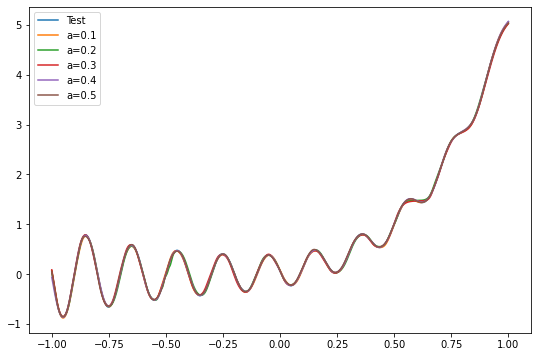

In [21]:
x_test = np.loadtxt('Gramacy&Lee(2012)_test.txt')[:, :1]
y_test = np.loadtxt('Gramacy&Lee(2012)_test.txt')[:, 1:]

plt.figure(figsize=(9,6))
plt.plot(x_test, y_test, label='Test')
for a in [0.1, 0.2, 0.3, 0.4, 0.5]:
    y_pred = np.loadtxt("test_{}_{}.txt".format(2,a))
    plt.plot(x_test, y_pred, label='a={}'.format(a) )
    print(L2_error(y_test, y_pred))
plt.legend()

[0.00879891]
[0.01647142]
[0.03333143]
[0.01279354]
[0.02058055]
[0.00738559]
[0.00699466]
[0.01442409]
[0.00951116]
[0.12826408]
[0.04671503]
[0.06918679]
[0.04403937]
[0.02943091]
[0.01318137]
[0.01529233]
[0.02084209]
[0.04486675]
[0.08888275]
[0.10041635]
[0.11107261]
[0.11942041]
[0.04167589]
[0.10704206]
[0.04890606]
[0.03143557]
[0.1245024]


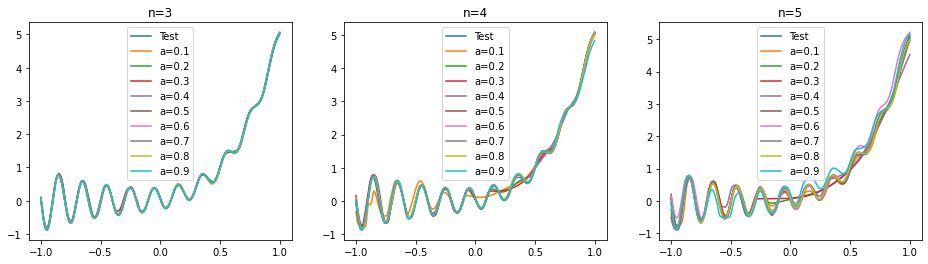

In [33]:
plt.figure(figsize=(16,4))

plt.subplot(131)
plt.plot(x_test, y_test, label='Test')
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred = np.loadtxt("test_{}_{}.txt".format(3,a))
    plt.plot(x_test, y_pred, label='a={}'.format(a) )
    print(L2_error(y_test, y_pred))
plt.title("n=3")
plt.legend()

plt.subplot(132)
plt.plot(x_test, y_test, label='Test')
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred = np.loadtxt("test_{}_{}.txt".format(4,a))
    plt.plot(x_test, y_pred, label='a={}'.format(a) )
    print(L2_error(y_test, y_pred))
plt.title("n=4")
plt.legend()

plt.subplot(133)
plt.plot(x_test, y_test, label='Test')
for a in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred = np.loadtxt("test_{}_{}.txt".format(5,a))
    plt.plot(x_test, y_pred, label='a={}'.format(a) )
    print(L2_error(y_test, y_pred))
plt.title("n=5")
plt.legend()

In [35]:
a1 = [0.1, 0.2, 0.3, 0.4, 0.5]
a2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
err2 = []
err3 = []
err4 = []
err5 = []

for a in a1:
    y_pred = np.loadtxt("test_{}_{}.txt".format(2,a))
    err2.append(L2_error(y_test, y_pred))


for a in a2:
    y_pred1 = np.loadtxt("test_{}_{}.txt".format(3,a))
    y_pred2 = np.loadtxt("test_{}_{}.txt".format(4,a))
    y_pred3 = np.loadtxt("test_{}_{}.txt".format(5,a))
    err3.append(L2_error(y_test, y_pred1))
    err4.append(L2_error(y_test, y_pred2))
    err5.append(L2_error(y_test, y_pred3))

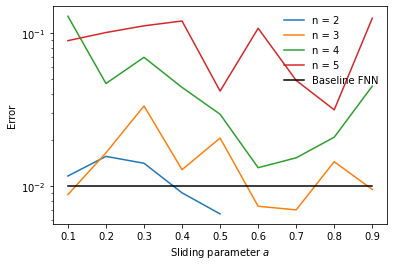

In [67]:
plt.semilogy(a1,err2, label='n = 2')
plt.semilogy(a2, err3, label='n = 3')
plt.semilogy(a2, err4, label='n = 4')
plt.semilogy(a2, err5, label='n = 5')
plt.semilogy(a2, np.repeat(1e-02,9), color='black',label = 'Baseline FNN')
plt.xlabel("Sliding parameter $a$")
plt.ylabel("Error")
plt.legend(frameon=False)

In [63]:
a1 = [0.1, 0.2, 0.3, 0.4, 0.5]
err2_1000 = []
err2_2000 = []
err2_3000 = []
err2_5000 = []
err2_10000 = []

for a in a1:
    y_pred1 = np.loadtxt("test_{}_{}_1000.txt".format(2,a))
    y_pred2 = np.loadtxt("test_{}_{}_2000.txt".format(2,a))
    y_pred3 = np.loadtxt("test_{}_{}_3000.txt".format(2,a))
    y_pred4 = np.loadtxt("test_{}_{}.txt".format(2,a))
    y_pred5 = np.loadtxt("test_{}_{}_10000.txt".format(2,a))
    err2_1000.append(L2_error(y_test, y_pred1))
    err2_2000.append(L2_error(y_test, y_pred2))
    err2_3000.append(L2_error(y_test, y_pred3))
    err2_5000.append(L2_error(y_test, y_pred4))
    err2_10000.append(L2_error(y_test, y_pred5))


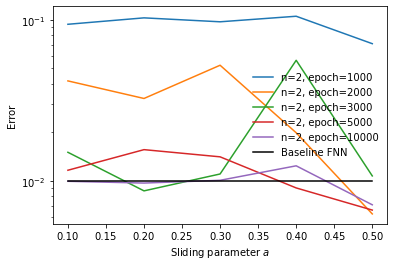

In [66]:
plt.semilogy(a1,err2_1000, label='n=2, epoch=1000')
plt.semilogy(a1, err2_2000, label='n=2, epoch=2000')
plt.semilogy(a1, err2_3000, label='n=2, epoch=3000')
plt.semilogy(a1, err2_5000, label='n=2, epoch=5000')
plt.semilogy(a1, err2_10000, label='n=2, epoch=10000')
plt.semilogy(a1, np.repeat(1e-02,5), color='black',label = 'Baseline FNN')
plt.xlabel("Sliding parameter $a$")
plt.ylabel("Error")
plt.legend(frameon=False)

### Training data points

Text(0.5, 1.0, 'a=0.3, n=5')

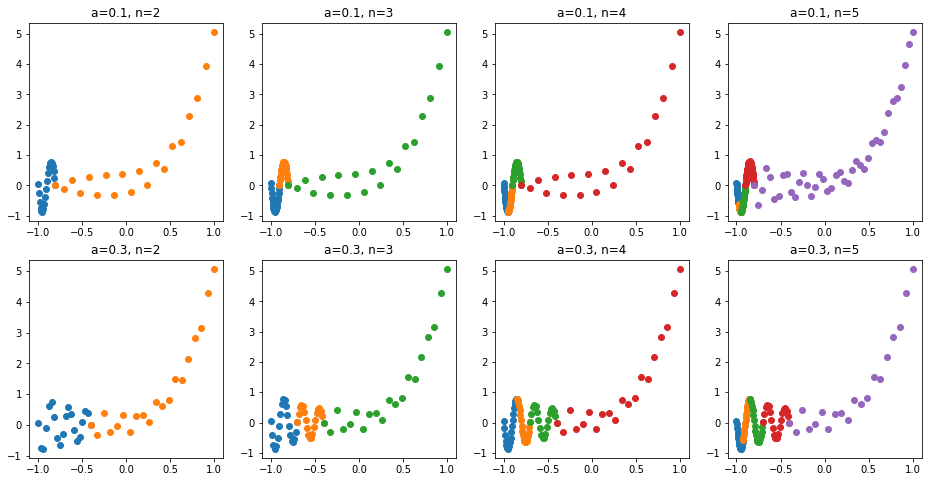

In [70]:
plt.figure(figsize=(16,8))
plt.subplot(241)
x = sorted([-1 + 2 * 0.1 * 0.5 ** n for n in range(0, 1)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.title("a=0.1, n=2")

plt.subplot(245)
x = sorted([-1 + 2 * 0.3 * 0.5 ** n for n in range(0, 1)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.title("a=0.3, n=2")

plt.subplot(242)
x = sorted([-1 + 2 * 0.1 * 0.5 ** n for n in range(0, 2)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.title("a=0.1, n=3")

plt.subplot(246)
x = sorted([-1 + 2 * 0.3 * 0.5 ** n for n in range(0, 2)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.title("a=0.3, n=3")

plt.subplot(243)
x = sorted([-1 + 2 * 0.1 * 0.5 ** n for n in range(0, 3)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.title("a=0.1, n=4")

plt.subplot(247)
x = sorted([-1 + 2 * 0.3 * 0.5 ** n for n in range(0, 3)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.title("a=0.3, n=4")

plt.subplot(244)
x = sorted([-1 + 2 * 0.1 * 0.5 ** n for n in range(0, 4)])
data1 = np.linspace(-1, x[0], 40)[:,None]
data2 = np.linspace(x[0], x[1], 40)[:,None]
data3 = np.linspace(x[1], x[2], 40)[:,None]
data4 = np.linspace(x[2], x[-1], 40)[:,None]
data5 = np.linspace(x[-1], 1, 40)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.scatter(data5, func(data5), label='sub interval5')
plt.title("a=0.1, n=5")

plt.subplot(248)
x = sorted([-1 + 2 * 0.3 * 0.5 ** n for n in range(0, 4)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], x[-1], 20)[:,None]
data5 = np.linspace(x[-1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.scatter(data5, func(data5), label='sub interval5')
plt.title("a=0.3, n=5")
    

Text(0.5, 1.0, 'a=0.9, n=5')

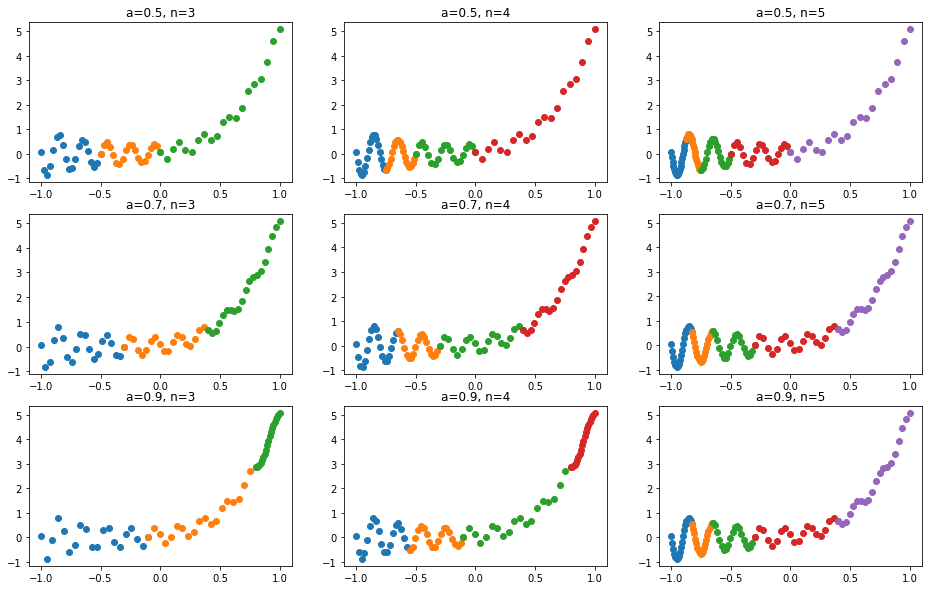

In [69]:
plt.figure(figsize=(16,10))
plt.subplot(331)
x = sorted([-1 + 2 * 0.5 * 0.5 ** n for n in range(0, 2)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.title("a=0.5, n=3")

plt.subplot(334)
x = sorted([-1 + 2 * 0.7 * 0.5 ** n for n in range(0, 2)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.title("a=0.7, n=3")

plt.subplot(337)
x = sorted([-1 + 2 * 0.9 * 0.5 ** n for n in range(0, 2)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.title("a=0.9, n=3")

plt.subplot(332)
x = sorted([-1 + 2 * 0.5 * 0.5 ** n for n in range(0, 3)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.title("a=0.5, n=4")

plt.subplot(335)
x = sorted([-1 + 2 * 0.7 * 0.5 ** n for n in range(0, 3)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.title("a=0.7, n=4")

plt.subplot(338)
x = sorted([-1 + 2 * 0.9 * 0.5 ** n for n in range(0, 3)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.title("a=0.9, n=4")

plt.subplot(333)
x = sorted([-1 + 2 * 0.5 * 0.5 ** n for n in range(0, 4)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], x[-1], 20)[:,None]
data5 = np.linspace(x[-1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.scatter(data5, func(data5), label='sub interval5')
plt.title("a=0.5, n=5")

plt.subplot(336)
x = sorted([-1 + 2 * 0.7 * 0.5 ** n for n in range(0, 4)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], x[-1], 20)[:,None]
data5 = np.linspace(x[-1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.scatter(data5, func(data5), label='sub interval5')
plt.title("a=0.7, n=5")

plt.subplot(339)
x = sorted([-1 + 2 * 0.7 * 0.5 ** n for n in range(0, 4)])
data1 = np.linspace(-1, x[0], 20)[:,None]
data2 = np.linspace(x[0], x[1], 20)[:,None]
data3 = np.linspace(x[1], x[2], 20)[:,None]
data4 = np.linspace(x[2], x[-1], 20)[:,None]
data5 = np.linspace(x[-1], 1, 20)[:,None]
plt.scatter(data1, func(data1), label='sub interval1')
plt.scatter(data2, func(data2), label='sub interval2')
plt.scatter(data3, func(data3), label='sub interval3')
plt.scatter(data4, func(data4), label='sub interval4')
plt.scatter(data5, func(data5), label='sub interval5')
plt.title("a=0.9, n=5")